# SECTION 0.0: COLAB PREP

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [1]:
# %cd gdrive/'My Drive'/hddmnn_tutorial

# !pip uninstall tensorflow  # tf 2.3.0 is loaded by default --> very slow on our networks
# !pip install tensorflow-gpu==1.15 # tf 1.15 ~ 4 times faster (feel free to test this out)
# !pip install pymc
# !pip install kabuki
# !pip install -U --no-deps git+https://github.com/alexanderfengler/hddm@nn_likelihood

[Errno 2] No such file or directory: 'gdrive/My Drive/hddmnn_tutorial'
/Users/afengler/OneDrive/git_repos/hddmnn_tutorial
Found existing installation: tensorflow 1.15.0
Uninstalling tensorflow-1.15.0:
  Would remove:
    /Users/afengler/opt/miniconda3/envs/hddm_dev/bin/estimator_ckpt_converter
    /Users/afengler/opt/miniconda3/envs/hddm_dev/bin/freeze_graph
    /Users/afengler/opt/miniconda3/envs/hddm_dev/bin/saved_model_cli
    /Users/afengler/opt/miniconda3/envs/hddm_dev/bin/tensorboard
    /Users/afengler/opt/miniconda3/envs/hddm_dev/bin/tf_upgrade_v2
    /Users/afengler/opt/miniconda3/envs/hddm_dev/bin/tflite_convert
    /Users/afengler/opt/miniconda3/envs/hddm_dev/bin/toco
    /Users/afengler/opt/miniconda3/envs/hddm_dev/bin/toco_from_protos
    /Users/afengler/opt/miniconda3/envs/hddm_dev/lib/python3.7/site-packages/tensorflow-1.15.0.dist-info/*
    /Users/afengler/opt/miniconda3/envs/hddm_dev/lib/python3.7/site-packages/tensorflow/*
    /Users/afengler/opt/miniconda3/envs/hddm_

In [1]:
# MODULE IMPORTS ----

# 
import hddm

# Make simulators visible
import sys
sys.path.append('simulators')

# Data management
import pandas as pd
import numpy as np
import pickle

# Plotting
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# Stats functionality
from statsmodels.distributions.empirical_distribution import ECDF

# CUSTOM IMPORTS (LOCAL FILES) --------
import cddm_data_simulation as cds
import boundary_functions as bf

from helper_functions import simulator
from helper_functions import simulator_covariate
from helper_functions import simulator_stimcoding
from helper_functions import model_plot
from helper_functions import caterpillar_plot
from helper_functions import posterior_pair_plot
# from helper_functions import hddm_preprocess_hierarchical
from helper_functions import simulator_condition_effects
from helper_functions import make_parameter_sets
from helper_functions import _make_trace_plotready_condition
from helper_functions import hddm_preprocess
from helper_functions import simulator_hierarchical
from helper_functions import posterior_predictive_plot
from helper_functions import hddm_include_config

# --------------------------------------

/Users/afengler/opt/miniconda3/envs/hddm_dev/lib/python3.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


In [2]:
p_outlier = []
include_conf = {'angle': ['z', 'theta'] + p_outlier,
                'weibull_cdf':['z', 'alpha', 'beta'] + p_outlier,
                'full_ddm': ['z', 'st', 'sv', 'sz'] + p_outlier,
                'levy': ['z', 'alpha'] + p_outlier,
                'ornstein': ['z', 'g'] + p_outlier,
                'ddm_sdv': ['z', 'sv'] + p_outlier,
                'ddm': ['z']}

# Single Subjects

In [ ]:
model = 'ornstein'
n_samples = 10000
p_outlier = [] # ['p_outlier']


params = make_parameter_sets(model = model,
                             n_parameter_sets = 1)

simulations = simulator(theta = params.values[0],
                        model = model,
                        n_samples = n_samples)

hddm_data_single_subject = hddm_preprocess(simulations)



# hddm_model_ddm_analytic_single_subject = hddm.HDDMnn(hddm_data_ddm_single_subject, 
#                                                          model = 'ddm_analytic',
#                                                          informative = False,
#                                                          include = ['z'],
#                                                          is_group_model = False)

# Defining a hddm model
hddm_model_single_subject = hddm.HDDMnn(hddm_data_single_subject,
                                        model = model,
                                        informative = False,
                                        include = include_conf[model],
                                        p_outlier = 0.0,
                                        w_outlier = 0.01,
                                        is_group_model = False)

In [ ]:
nmcmc = 300
hddm_model_single_subject.sample(nmcmc, 
                                     burn = 100)

In [ ]:
print('dic: ', hddm_model_single_subject.dic)
print(hddm_model_single_subject.gen_stats()['mean'])
print('gt params: ', params)

In [ ]:
params

In [ ]:
posterior_predictive_plot(posterior_samples = hddm_model_single_subject.get_traces(), #hddm_model_weibull_single_subject.get_traces(),
                          ground_truths_parameters = params.values[0], #weibull_params.values[0],
                          ground_truths_data = np.concatenate([simulations[0], simulations[1]], axis = 1), # None
                          n_plots = 1,
                          cols = 1,
                          model_fitted = model,
                          model_gt = None, #'levy', #'weibull_cdf',
                          datatype = 'single_subject',
                          n_post_params = 200,
                          samples_by_param = 100,
                          xlimit = 10,
                          bin_size = 0.025,
                          hist_linewidth = 1)

In [ ]:
# Caterpillar Plot: (Parameters recovered ok?)
caterpillar_plot(posterior_samples = hddm_model_single_subject.get_traces(),
                 ground_truths = params.values[0], #weibull_params.values[0],
                 model = model,
                 datatype = 'single_subject',
                 drop_sd = True)

# CONDITION

In [ ]:
model = 'ornstein'
n_samples_by_condition = 500
p_outlier = [] # ['p_outlier']


hddm_data_condition, gt_condition, gt_mat_condition = simulator_condition_effects(n_conditions = 4,
                                                                                  n_samples_by_condition = n_samples_by_condition,
                                                                                  condition_effect_on_param = ['v', 'a'],
                                                                                  model = model)


hddm_model_condition = hddm.HDDMnn(hddm_data_condition, 
                                   model = model,
                                   informative = False,
                                   include = include_conf[model],
                                   p_outlier = 0.,
                                   w_outlier = 0.,
                                   is_group_model = False, 
                                   depends_on = {'v': 'condition', 'a': 'condition'})


hddm_model_condition.sample(500, burn = 100)

In [ ]:
# Caterpillar Plot: (Parameters recovered ok?)
caterpillar_plot(posterior_samples = hddm_model_condition.get_traces(),
                 ground_truths = gt_condition, #weibull_params.values[0],
                 model = model,
                 datatype = 'condition',
                 drop_sd = True)

# GROUP

In [2]:
model = 'angle'
n_subjects = 10
n_samples_by_subject = 500
p_outlier = [] # ['p_outlier']


# Simulate data angle
hddm_data_hierarchical, gt_hierarchical, gt_mat_hierarchical = simulator_hierarchical(n_subjects = n_subjects,
                                                                                      model = model,
                                                                                      n_samples_by_subject = n_samples_by_subject)


hddm_hierarchical_model = hddm.HDDMnn(hddm_data_hierarchical, 
                                                    model = model,
                                                    informative = False,
                                                    include = include_conf[model],
                                                    p_outlier = 0,
                                                    w_outlier = 0,
                                                    is_group_model = True)

# # Sampling:
nmcmc = 500
hddm_hierarchical_model.sample(nmcmc,
                               burn = 100)

NameError: name 'simulator_hierarchical' is not defined

In [ ]:
# Subset data?
hddm_data_hierarchical_limited = hddm_data_hierarchical.iloc[:2500]
str_allowed = ['005', 
               '006', 
               '007', 
               '008', 
               '009', 
               '010', 
               '011', 
               '012', 
               '013', 
               '014', 
               '015', 
               '016',
               '017',
               '018',
               '019']
gt_hierarchical_limited = (gt_hierarchical).copy()
for str_tmp in gt_hierarchical.keys():
    for str_allowed_tmp in str_allowed:
        if str_allowed_tmp in str_tmp:
            gt_hierarchical_limited.pop(str_tmp)

In [ ]:
# Caterpillar Plot
caterpillar_plot(posterior_samples = hddm_hierarchical_model.get_traces(),
                 ground_truths = gt_hierarchical,
                 model = model,
                 datatype = 'hierarchical',
                 x_lims = [-2, 2],
                 aspect_ratio = 2,
                 drop_sd = False,
                 save = False)

# Regression

In [ ]:
# Ornstein params
model = 'ddm'
n_samples = 1000

params =  make_parameter_sets(model = model,
                              n_parameter_sets = 1)

simulations = simulator(theta = params.values[0],
                        model = model, 
                        n_samples = n_samples)

hddm_data_single_subject_regress = hddm_preprocess(simulations)

# Add a regressor:
hddm_data_single_subject_regress['BOLD'] = np.random.uniform(low = - 1, high = 1, size = n_samples)

#v_reg = {'model': 'v ~ 1 + BOLD', 'link_func': lambda x: x}
#a_reg = {'model': 'a ~ 1 + BOLD', 'link_func': lambda x: x}
#t_reg = {'model': 't ~ 1 + BOLD', 'link_func': lambda x: x}
g_reg = {'model': 'a ~ 1 + BOLD', 'link_func': lambda x: x}

reg_descr = [g_reg] #[v_reg, a_reg, t_reg, g_reg] # theta_reg]

hddm_reg = hddm.HDDMnnRegressor(hddm_data_single_subject_regress, 
                                reg_descr, 
                                include = set(include_conf[model]),
                                model = model)

In [ ]:
# # Sampling:
nmcmc = 500
hddm_reg.sample(nmcmc,
                burn = 100)

# CNN TESTS

In [25]:
nmcmc = 1000
model = 'ornstein'
n_samples = 500
# n_samples_by_condition = 500
# split_param = 'z'
includes = hddm_include_config[model]
p_outlier = [] # empty of ['p_outlier']
includes += p_outlier

In [26]:
#model = 'angle'
params =  make_parameter_sets(model = model,
                              n_parameter_sets = 1)

simulations = simulator(theta = params.values[0],
                        model = model, 
                        n_samples = n_samples,
                        bin_pointwise = True,
                        max_t = 10.0,
                        bin_dim = 512)

In [27]:
simulations[0]

array([[106],
       [ 83],
       [105],
       [108],
       [ 83],
       [ 93],
       [ 87],
       [100],
       [ 86],
       [ 82],
       [ 89],
       [ 92],
       [ 82],
       [ 91],
       [ 84],
       [ 82],
       [148],
       [ 88],
       [101],
       [ 84],
       [ 91],
       [125],
       [ 90],
       [ 88],
       [ 87],
       [ 92],
       [ 94],
       [ 89],
       [ 89],
       [ 90],
       [ 86],
       [ 92],
       [ 98],
       [101],
       [ 86],
       [ 93],
       [ 96],
       [ 91],
       [ 89],
       [105],
       [ 95],
       [ 87],
       [ 89],
       [ 92],
       [ 96],
       [ 89],
       [ 86],
       [ 83],
       [ 87],
       [107],
       [ 89],
       [ 97],
       [ 90],
       [111],
       [ 91],
       [ 84],
       [ 86],
       [ 90],
       [ 91],
       [ 83],
       [ 85],
       [ 83],
       [ 85],
       [ 83],
       [ 89],
       [ 89],
       [ 96],
       [ 86],
       [ 95],
       [ 95],
       [ 85],
      

In [28]:
hddm_binned_data = hddm_preprocess(simulations)
hddm_binned_data['rt'] = hddm_binned_data['rt'].values.astype(np.int)
hddm_binned_data['response'] = hddm_binned_data['response'].values.astype(np.int)

In [29]:
hddm_binned_data

,rt,response,nn_response,subj_idx
0,106,0,0,none
1,83,0,0,none
2,105,1,1,none
3,108,1,1,none
4,83,0,0,none
...,...,...,...,...
495,91,0,0,none
496,85,0,0,none
497,85,1,1,none
498,92,0,0,none


In [30]:
#hddm_binned_data_old = hddm_binned_data

In [31]:
hddm_model = hddm.HDDMnn(hddm_binned_data, 
                         model = model,
                         network_type = 'cnn',
                         informative = False,
                         include = includes,
                         p_outlier = 0.00)

/Users/afengler/opt/miniconda3/envs/hddm_dev/lib/python3.7/site-packages/hddm/cnn_models/ornstein_training_data_binned_1_nbins_512_n_100000
/Users/afengler/opt/miniconda3/envs/hddm_dev/lib/python3.7/site-packages/hddm/cnn_models/ornstein_training_data_binned_1_nbins_512_n_100000
Now adding the HDDMBase include:
Include from inside HDDMBase:  {'a', 'v', 't'}
Recognized HDDMnn
knodes
OrderedDict([('a_bottom', a), ('v_bottom', v), ('t_bottom', t), ('z_trans', z_trans), ('z_bottom', z), ('g_bottom', g)])
wfpt parents: 
OrderedDict([('a', a), ('v', v), ('t', t), ('z', z), ('p_outlier', 0.0), ('w_outlier', 0.1), ('g', g)])
Is Neural Net?  True
0.0


In [32]:
hddm_model.sample(500,
                  burn = 50, dbname = 'traces.db', db = 'pickle')

 [-----------------100%-----------------] 500 of 500 complete in 16.0 sec

In [33]:
hddm_model.gen_stats()

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a,0.439428,0.0164091,0.41029,0.428832,0.438738,0.447546,0.47812,0.00135035
v,0.251793,0.127805,0.0136183,0.172323,0.253369,0.326658,0.501576,0.0100661
t,1.6039,0.00398537,1.59601,1.60129,1.60431,1.6066,1.61054,0.000333816
z,0.378682,0.0225333,0.332958,0.363014,0.378967,0.394073,0.420627,0.00191243
g,0.397511,0.4901,-0.804422,0.12254,0.505501,0.806843,0.984948,0.0405891


In [34]:
params

,v,a,z,g,t
0,0.03276,0.440624,0.427381,0.584622,1.591931


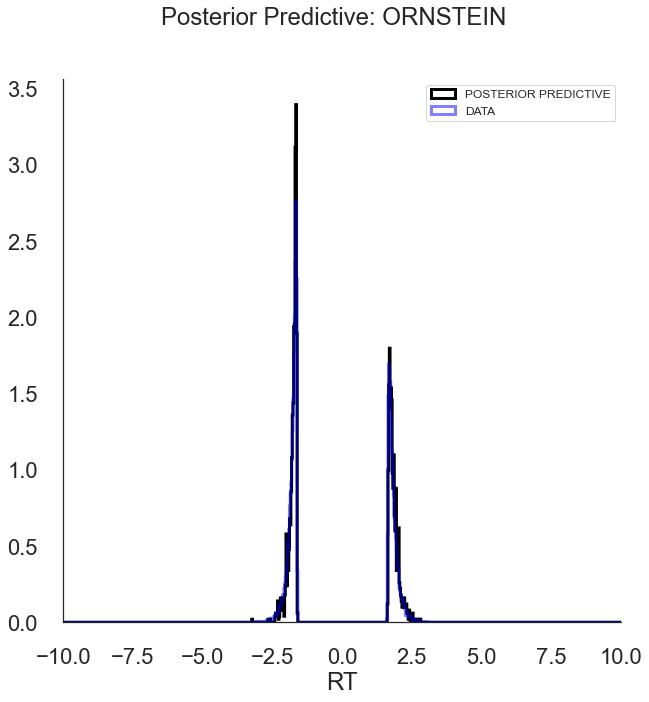

In [35]:
# Posterior Predictive: Do we generate meaningful data from the Posterior Model?
simulations_plot = simulator(theta = params.values[0],
                             model = model, 
                             n_samples = 20000,
                             bin_pointwise = False,
                             max_t = 10.0,
                             bin_dim = None)

posterior_predictive_plot(ground_truths_parameters = params.values[0],
                          ground_truths_data = np.concatenate([simulations_plot[0], simulations_plot[1]], axis = 1),
                          posterior_samples = hddm_model.get_traces(),
                          model_gt = None,
                          model_fitted = model,
                          n_post_params = 200,
                          n_plots = 1,
                          max_t = 10, 
                          input_hddm_trace = True,
                          datatype = 'single_subject',
                          hist_linewidth = 3)

UnboundLocalError: local variable 'b' referenced before assignment

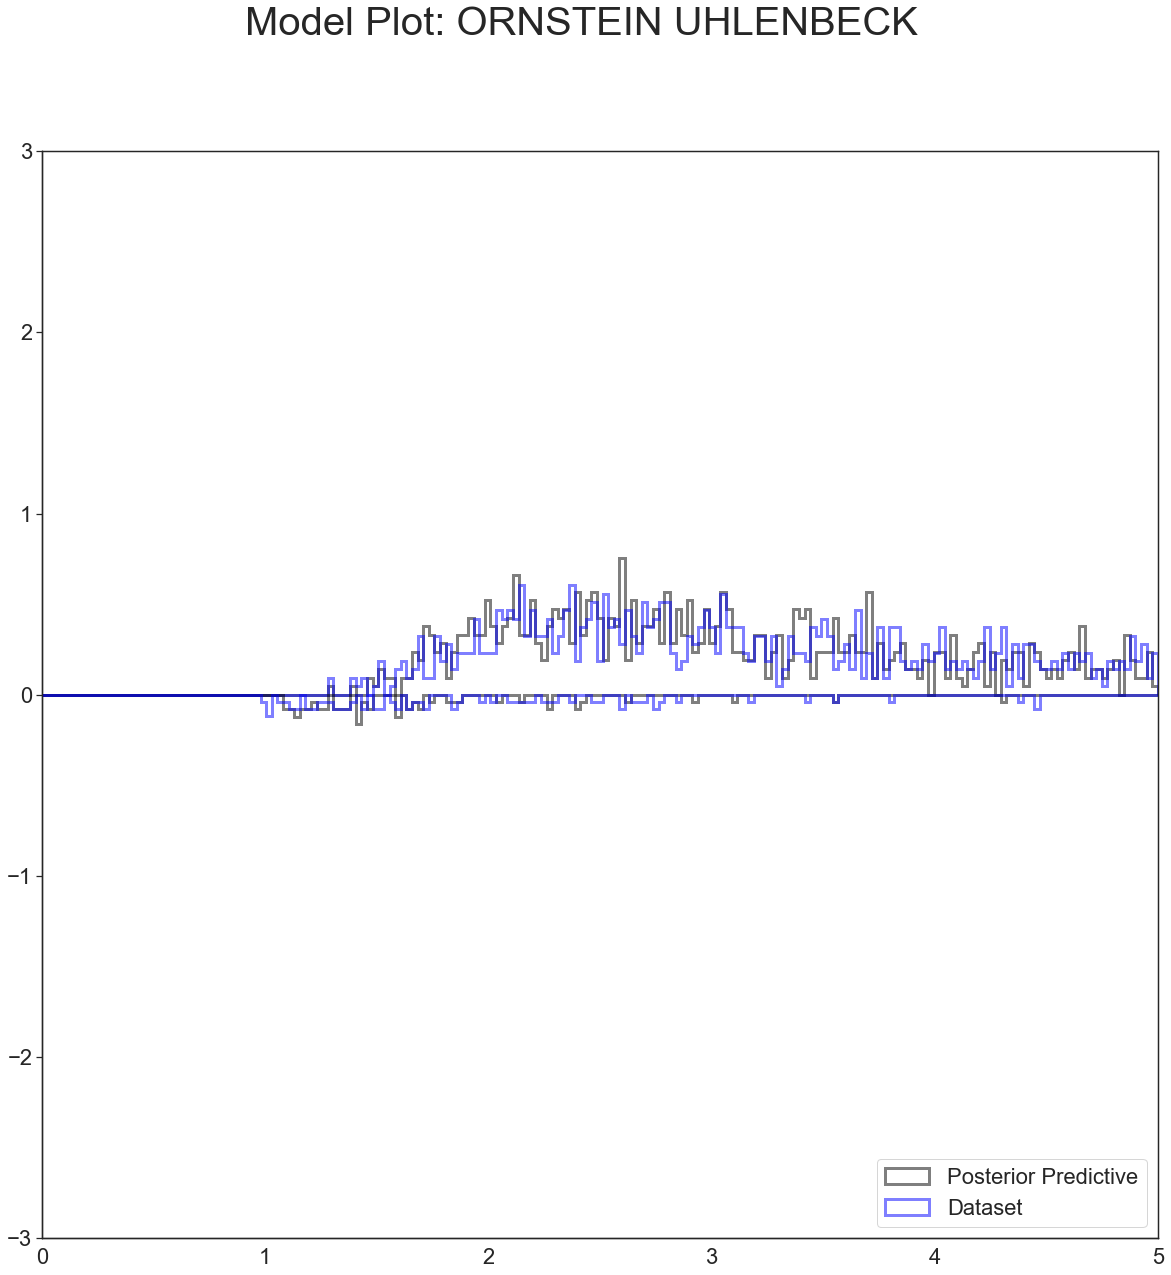

In [53]:
# Posterior Predictive: Do we generate meaningful data from the Posterior Model?
model_plot(ground_truths_parameters = params.values[0],
           ground_truths_data = np.concatenate([simulations_plot[0], simulations_plot[1]], axis = 1),
           posterior_samples = hddm_model.get_traces(),
           model_gt = model,
           model_fitted = model,
           n_post_params = 100,
           cols = 1,
           n_plots = 1,
           max_t = 5, 
           show_model = True,
           input_hddm_trace = True,
           datatype = 'single_subject',
           ylimit = 3,
           posterior_linewidth = 3,
           gt_linewidth = 3,
           hist_linewidth = 3,)

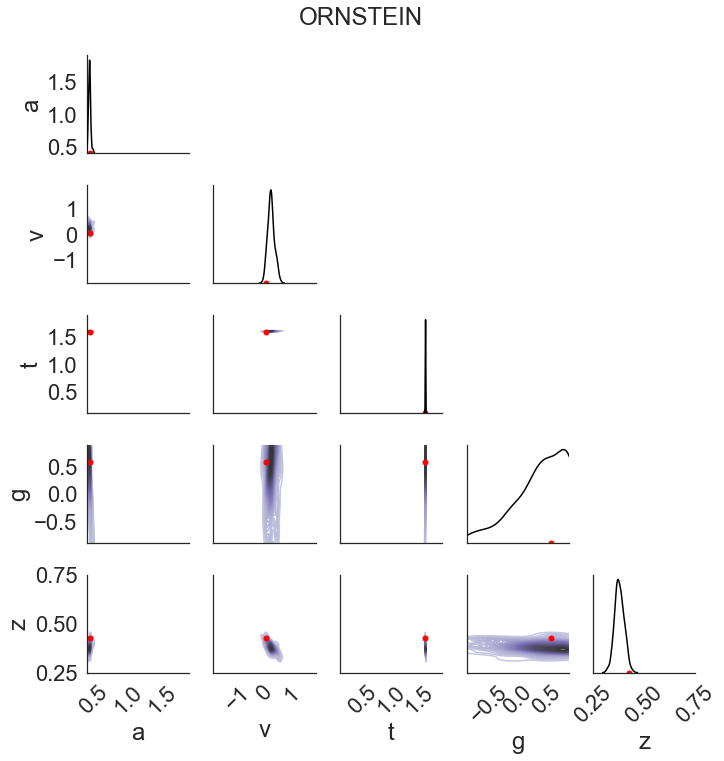

In [36]:
posterior_pair_plot(posterior_samples = hddm_model.get_traces(),
                    height = 10,
                    aspect = 1,
                    n_subsample = 200,
                    ground_truths = params.values[0],
                    model = model)

In [12]:
#hddm_model.dbname = 'disk'


In [76]:
#hddm_model.mc.db.__name__
hddm_model.mc.db.filename 

'traces.db'

In [37]:
hddm_model.mc.db.__name__ = 'pickle'
hddm_model.mc.db.filename = 'test_traces.pickle'

In [12]:
hddm_model.save('hddm_model_test_saver.pickle')

{'network_type': 'cnn', 'network': <bound method Infer.forward of <hddm.cnn.wrapper.Infer object at 0x1060f2190>>, 'non_centered': False, 'w_outlier': 0.1, 'model': 'angle', 'nbin': 512, 'wfpt_nn': <class 'pymc.distributions.new_dist_class.<locals>.new_class'>, 'slice_widths': {'a': 1, 't': 0.01, 'a_std': 1, 't_std': 0.15, 'sz': 1.1, 'v': 1.5, 'st': 0.1, 'sv': 0.5, 'z_trans': 0.2, 'z': 0.1, 'p_outlier': 1.0, 'v_std': 1, 'alpha': 1.0, 'dual_alpha': 1.5, 'theta': 0.1, 'beta': 1.0, 'g': 0.5}, 'emcee_dispersions': {'a': 1, 't': 0.1, 'a_std': 1, 't_std': 0.15, 'sz': 1.1, 'v': 1.5, 'st': 0.1, 'sv': 3, 'z_trans': 0.2, 'z': 0.1, 'p_outlier': 1.0, 'v_std': 1, 'alpha': 1.5, 'dual_alpha': 1.5, 'theta': 0.1}, 'is_informative': False, 'default_intervars': {'sz': 0, 'st': 0, 'sv': 0}, '_kwargs': {'nn': True}, 'include': {'v', 'a', 't', 'theta', 'z'}, 'wiener_params': {'err': 0.0001, 'n_st': 2, 'n_sz': 2, 'use_adaptive': 1, 'simps_err': 0.001, 'w_outlier': 0.1}, 'p_outlier': 0.0, 'cdf_range': (-76, 7

In [13]:
new_mod = hddm.load('hddm_model_test_saver.pickle')

/Users/afengler/opt/miniconda3/envs/hddm_dev/lib/python3.7/site-packages/hddm/cnn_models/angle_training_data_binned_1_nbins_512_n_100000
/Users/afengler/opt/miniconda3/envs/hddm_dev/lib/python3.7/site-packages/hddm/cnn_models/angle_training_data_binned_1_nbins_512_n_100000
{'network_type': 'cnn', 'non_centered': False, 'w_outlier': 0.1, 'model': 'angle', 'nbin': 512, 'slice_widths': {'a': 1, 't': 0.01, 'a_std': 1, 't_std': 0.15, 'sz': 1.1, 'v': 1.5, 'st': 0.1, 'sv': 0.5, 'z_trans': 0.2, 'z': 0.1, 'p_outlier': 1.0, 'v_std': 1, 'alpha': 1.0, 'dual_alpha': 1.5, 'theta': 0.1, 'beta': 1.0, 'g': 0.5}, 'emcee_dispersions': {'a': 1, 't': 0.1, 'a_std': 1, 't_std': 0.15, 'sz': 1.1, 'v': 1.5, 'st': 0.1, 'sv': 3, 'z_trans': 0.2, 'z': 0.1, 'p_outlier': 1.0, 'v_std': 1, 'alpha': 1.5, 'dual_alpha': 1.5, 'theta': 0.1}, 'is_informative': False, 'default_intervars': {'sz': 0, 'st': 0, 'sv': 0}, '_kwargs': {'nn': True}, 'include': {'v', 'a', 't', 'theta', 'z'}, 'wiener_params': {'err': 0.0001, 'n_st': 2,

In [14]:
new_mod.gen_stats()

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a,1.47064,0.0883471,1.30669,1.38173,1.53053,1.54245,1.55804,0.0124942
v,1.54158,0.0666659,1.42556,1.48936,1.54932,1.60046,1.64558,0.00942798
t,0.562424,0.00703201,0.552208,0.556105,0.564165,0.567395,0.575283,0.000994476
z,0.335686,0.00742979,0.322774,0.330833,0.336416,0.342172,0.34808,0.00105073
theta,0.967539,0.0422754,0.874378,0.941388,0.993801,0.998191,1.00626,0.00597865


In [15]:
hddm_model.gen_stats()

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a,1.47064,0.0883471,1.30669,1.38173,1.53053,1.54245,1.55804,0.0124942
v,1.54158,0.0666659,1.42556,1.48936,1.54932,1.60046,1.64558,0.00942798
t,0.562424,0.00703201,0.552208,0.556105,0.564165,0.567395,0.575283,0.000994476
z,0.335686,0.00742979,0.322774,0.330833,0.336416,0.342172,0.34808,0.00105073
theta,0.967539,0.0422754,0.874378,0.941388,0.993801,0.998191,1.00626,0.00597865


In [11]:
params

,v,a,z,t
0,0.799141,1.020869,0.576349,1.787239


In [ ]:
import tensorflow as tf
from hddm.cnn.wrapper import Infer
from hddm.cnn.config import *
tf.reset_default_graph()
InferenceClass = Infer(config = Config('ddm', 512))

In [ ]:
#params = np.zeros((1, 1, 4, 1))
tiny_x = np.array([-1.0, 2.0, 0.5, 2.0])
#tiny_x = np.zeros(4)
#tiny_x = np.expand_dims(tiny_x, axis = (0, 1, 3))
x = InferenceClass.forward(tiny_x)

#0.50	1.150202	0.601982	0.580975

In [ ]:
import numpy as np
from .train_detector import cnn_model_struct
from .config import *
import tensorflow as tf
import tqdm, gzip, cProfile, time, argparse, pickle, os
# just to prevent tensorflow from printing logs
os.environ['TF_CPP_MIN_LOG_LEVEL']="2"
tf.logging.set_verbosity(tf.logging.ERROR)

class Infer:
	def __init__(self, config):
		self.cfg = config
		self.target = []
		self.inp = tf.placeholder(tf.float32, self.cfg.test_param_dims)
		self.initialized = False

		with tf.device('/gpu:0'):
			with tf.variable_scope("model", reuse=tf.AUTO_REUSE) as scope:
				self.model = cnn_model_struct()
				self.model.build(self.inp, self.cfg.test_param_dims[1:], self.cfg.output_hist_dims[1:], train_mode=False, verbose=False)
				self.gpuconfig = tf.ConfigProto()
				self.gpuconfig.gpu_options.allow_growth = True
				self.gpuconfig.allow_soft_placement = True
				self.saver = tf.train.Saver()
		
		self.sess = tf.Session(config=self.gpuconfig)
		print(self.cfg.model_output)
		ckpts = tf.train.latest_checkpoint(self.cfg.model_output)
		self.saver.restore(self.sess, ckpts)

	def __getitem__(self, item):
		return getattr(self, item)

	def __contains__(self, item):
		return hasattr(self, item)

	def forward(self, params):
		pred_hist = self.sess.run(self.model.output, feed_dict={self.inp:params.reshape(self.cfg.test_param_dims)})
		return pred_hist

def load_cnn(model, nbin):
	cfg = Config(model=model, bins=nbin)
	inference_class = Infer(config=cfg)
	return inference_class.forward


if __name__ == '__main__':
	parser = argparse.ArgumentParser()
	parser.add_argument('--model', type=str)
	parser.add_argument('--nbin', type=int)
	args = parser.parse_args()

	cfg = Config(model=args.model, bins=args.nbin)
	inference_class = Infer(config=cfg)

	example_params = np.array([0., 1.5, 0.5, 1])
	print(inference_class.forward(example_params))

# SAVING MODEL

In [3]:
model = 'ddm'
n_samples = 1000
p_outlier = [] # ['p_outlier']


params = make_parameter_sets(model = model,
                             n_parameter_sets = 1)

simulations = simulator(theta = params.values[0],
                        model = model,
                        n_samples = n_samples)

hddm_data_single_subject = hddm_preprocess(simulations)



# hddm_model_ddm_analytic_single_subject = hddm.HDDMnn(hddm_data_ddm_single_subject, 
#                                                          model = 'ddm_analytic',
#                                                          informative = False,
#                                                          include = ['z'],
#                                                          is_group_model = False)

# Defining a hddm model
hddm_model_single_subject = hddm.HDDM(hddm_data_single_subject,
                                      informative = False,
                                      include = include_conf[model],
                                      p_outlier = 0.0,
                                      is_group_model = False)

Now adding the HDDMBase include:
Include from inside HDDMBase:  {'t', 'a', 'v'}
Is Neural Net?  False


In [4]:
hddm_model_single_subject.sample(500, burn = 100, dbname = 'traces.db', db = 'pickle')

 [-----------------100%-----------------] 500 of 500 complete in 6.7 sec

In [5]:
hddm_model_single_subject.mc.db.__name__ 

'pickle'

In [6]:

hddm_model_single_subject.mc.db.filename 

'traces.db'

In [7]:
hddm_model_single_subject.save('test_hddm_saver.pickle')

{'slice_widths': {'a': 1, 't': 0.01, 'a_std': 1, 't_std': 0.15, 'sz': 1.1, 'v': 1.5, 'st': 0.1, 'sv': 0.5, 'z_trans': 0.2, 'z': 0.1, 'p_outlier': 1.0, 'v_std': 1, 'alpha': 1.0, 'dual_alpha': 1.5, 'theta': 0.1, 'beta': 1.0, 'g': 0.5}, 'emcee_dispersions': {'a': 1, 't': 0.1, 'a_std': 1, 't_std': 0.15, 'sz': 1.1, 'v': 1.5, 'st': 0.1, 'sv': 3, 'z_trans': 0.2, 'z': 0.1, 'p_outlier': 1.0, 'v_std': 1, 'alpha': 1.5, 'dual_alpha': 1.5, 'theta': 0.1}, 'is_informative': False, 'default_intervars': {'sz': 0, 'st': 0, 'sv': 0}, '_kwargs': {'is_group_model': False}, 'include': {'z', 't', 'v', 'a'}, 'wiener_params': {'err': 0.0001, 'n_st': 2, 'n_sz': 2, 'use_adaptive': 1, 'simps_err': 0.001, 'w_outlier': 0.1}, 'p_outlier': 0.0, 'cdf_range': (-7.851844310760498, 7.851844310760498), 'wfpt_class': <class 'pymc.distributions.new_dist_class.<locals>.new_class'>, 'nn': False, 'std_depends': False, 'plot_subjs': False, 'depends_on': None, 'data':            rt  response  nn_response subj_idx
0    1.535084  